In [1]:
import importlib
import sys
sys.path.append('../src')

import qa
importlib.reload(qa)
import qa
from plot import plot_from_file

import pickle
import numpy as np
import pandas as pd

import re
import random
import ast

In [ ]:
PATH = '../data/MMLU-Pro/results/mmlu_one_2nd.pkl'
results = pickle.load(open(PATH, 'rb'))
accuracy = [r['r^org']==r['answer'] for r in results]
conf = [r['p_r^org'] for r in results]



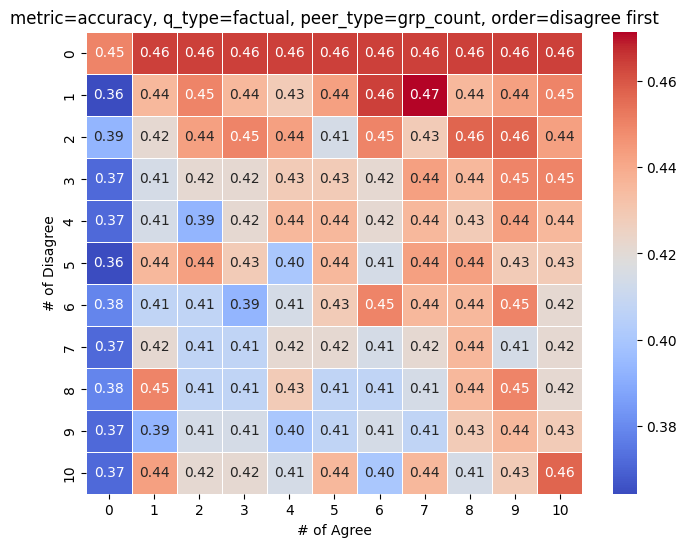

In [5]:
PATH = '../data/MMLU-Pro/results/mmlu_count_da.pkl'
plot_from_file(PATH, metric = 'accuracy')


# MMLU

In [ ]:
from datasets import load_dataset

ds = load_dataset("TIGER-Lab/MMLU-Pro")

mmlu = {}
for ele in ds['test']:
    if ele['category'] not in mmlu:
        mmlu[ele['category']] = []
    mmlu[ele['category']].append(ele)

import random

# mmlu_samples = []
# for cat in mmlu:
#     mmlu_samples.extend(random.Random(0).sample(mmlu[cat], 10))

# with open('../data/mmlu_samples_140.pkl', 'wb') as f:
#     pickle.dump(mmlu_samples, f)

mmlu_full = []
for cat in mmlu:
    mmlu_full.extend(mmlu[cat])
    
with open('../data/MMLU-Pro/results/mmlu_full.pkl', 'wb') as f:
    pickle.dump(mmlu_full, f)

print("total number of questions in MMLU-Pro:", len(mmlu_full))

res_oqa_org = qa.qa_eval_org(mmlu_full)

with open('../data/MMLU-Pro/results/mmlu_org.pkl', 'wb') as f:
    pickle.dump(res_oqa_org, f)

/home/jch0/.conda/envs/jch0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating validation split: 100%|██████████| 70/70 [00:00<00:00, 19347.70 examples/s]


total number of questions in MMLU-Pro: 12032


Processing MMLU: 100%|██████████| 12032/12032 [03:19<00:00, 60.35it/s] 


In [ ]:
with open('../data/MMLU-Pro/results/mmlu_org.pkl', 'rb') as f:
    res_mmlu_org = pickle.load(f)

type_names = ['1st', '2nd', 'rnd', 'lst']
for disagree_type in type_names:
    results = qa.qa_eval_one(res_mmlu_org, disagree_type)

    with open(f'../data/MMLU-Pro/results/mmlu_one_{disagree_type}.pkl', 'wb') as f:
        pickle.dump(results, f)

Processing MMLU: 100%|██████████| 12032/12032 [03:22<00:00, 59.41it/s] 


In [ ]:
with open('../data/MMLU-Pro/sample_results/res_mmlu_org.pkl', 'rb') as f:
    res_mmlu_org = pickle.load(f)


input_feat_list = []
for disagree_size in range(11): # row
    input_row = []
    for agree_size in range(11): # column
        
        eval_feat = {
            'type': 'grp_count',
            'agree_size': agree_size,
            'disagree_size': disagree_size,
            'disagree_type': '2nd',
            'q_type': 'factual',
            'order': 'da'
        }
        input_row.append(eval_feat)
    input_feat_list.append(input_row)

results, accuracy = qa.qa_eval_matrix(res_mmlu_org, input_feat_list)
    #     result, accuracy = qa.qa_eval_matrix(res_mmlu_org, eval_feat)
    #     output_row.append(accuracy)
    # output_list.append(output_row)

# round a 2d np array
accuracy = np.array([[round(ele,2) for ele in row] for row in accuracy])

with open('../data/MMLU-Pro/sample_results/mmlu_count_da.pkl', 'wb') as f:
    pickle.dump(results, f)


Processing grp_count samples...


Processing MMLU: 100%|██████████| 16940/16940 [05:58<00:00, 47.32it/s]


In [ ]:
with open('../data/MMLU-Pro/sample_results/res_mmlu_org.pkl', 'rb') as f:
    res_mmlu_org = pickle.load(f)


input_feat_list = []
for group_size in [4,12,50,100,1000]: # row
    input_row = []
    for agree_ratio in [0, 0.25, 0.50, 0.75, 1]: # column
        
        eval_feat = {
            'type': 'grp_ratio',
            'group_size': group_size,
            'disagree_ratio': 1-agree_ratio,
            'disagree_type': '2nd',
            'q_type': 'factual',
            'order': 'ad'
        }
        input_row.append(eval_feat)
    input_feat_list.append(input_row)

results, accuracy = qa.qa_eval_matrix(res_mmlu_org, input_feat_list)
    #     result, accuracy = qa.qa_eval_matrix(res_mmlu_org, eval_feat)
    #     output_row.append(accuracy)
    # output_list.append(output_row)

# round a 2d np array
accuracy = np.array([[round(ele,2) for ele in row] for row in accuracy])

with open('../data/MMLU-Pro/sample_results/mmlu_ratio_ad.pkl', 'wb') as f:
    pickle.dump(results, f)


Processing grp_ratio samples...


Processing MMLU: 100%|██████████| 3500/3500 [01:17<00:00, 45.36it/s]


## Reason Generation and Reason in-context

In [ ]:
with open('../data/MMLU-Pro/sample_results/res_mmlu_org.pkl', 'rb') as f:
    res_mmlu_org = pickle.load(f)

## bar plot for self-confidence vs consistency

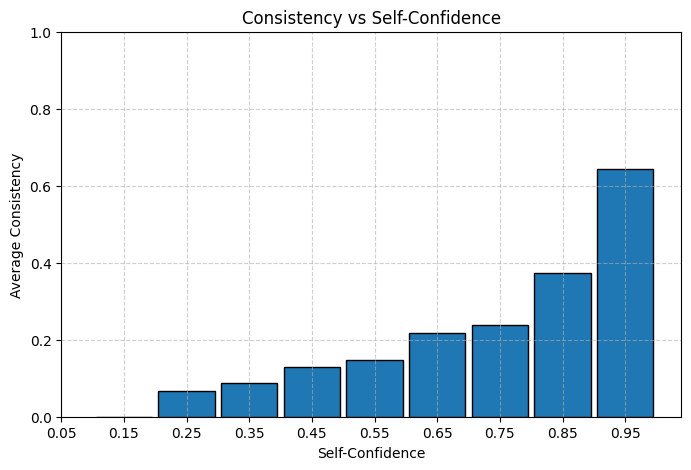

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load data
PATH = '../data/MMLU-Pro/results/mmlu_one_2nd.pkl'
with open(PATH, 'rb') as f:
    results = pickle.load(f)

# Extract accuracy and confidence
accuracy = np.array([r['r'] == r['answer'] for r in results])
consistency = np.array([r['r'] == r['r^org'] for r in results])
self_conf = np.array([r['p_r^org'] for r in results])
other_conf = np.array([r['p_r_j'] for r in results])

# Bin confidence scores into 10 bins from 0 to 1
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(self_conf, bins) - 1  # Adjust bin index to start at 0

# Calculate average accuracy for each bin
bin_accuracy = []
bin_centers = []

for i in range(10):
    indices = bin_indices == i
    if np.any(indices):
        avg_acc = consistency[indices].mean()
    else:
        avg_acc = np.nan
    bin_accuracy.append(avg_acc)
    bin_centers.append((bins[i] + bins[i+1]) / 2)

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, bin_accuracy, width=0.09, edgecolor='black')
plt.xlabel('Self-Confidence')
plt.ylabel('Average Consistency')
plt.title('Consistency vs Self-Confidence')
plt.xticks(np.round(bin_centers, 2))
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

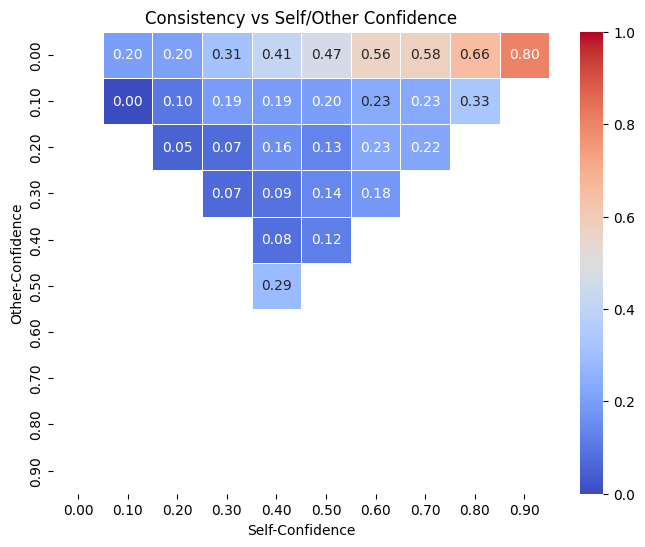

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
results = []
type_names = ['2nd', 'rnd', 'lst']
for type_name in type_names:
    PATH = f'../data/MMLU-Pro/results/mmlu_one_{type_name}.pkl'
    with open(PATH, 'rb') as f:
        results.extend(pickle.load(f))

# Extract accuracy and confidence
accuracy = np.array([r['r'] == r['answer'] for r in results])
consistency = np.array([r['r'] == r['r^org'] for r in results])
self_conf = np.array([r['p_r^org'] for r in results])
other_conf = np.array([r['p_r_j'] for r in results])

# Bin confidence scores into 10 bins from 0 to 1
bins = np.linspace(0, 1, 11)
row_bin_indices = np.digitize(other_conf, bins) - 1  # Adjust bin index to start at 0
col_bin_indices = np.digitize(self_conf, bins) - 1

accuracy = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        indices = (row_bin_indices == i) & (col_bin_indices == j)
        if np.any(indices):
            avg_acc = consistency[indices].mean()
        else:
            avg_acc = np.nan
        accuracy[i, j] = avg_acc

row_labels = ['{:.2f}'.format(i/10) for i in range(10)]
col_labels = ['{:.2f}'.format(i/10) for i in range(10)]
x_label = 'Self-Confidence'
y_label = 'Other-Confidence'
title = 'Consistency vs Self/Other Confidence'
vlimit = (0, 1)
df = pd.DataFrame(accuracy, index=row_labels, columns=col_labels)

plt.figure(figsize=(8, 6))

if vlimit:
    vmin, vmax = vlimit
    sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=vmin, vmax=vmax)
else:
    sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()


# OpinionQA

In [ ]:
oqa_df = pd.DataFrame()
# get all file names under PATH
import os
PATH = '../data/OpinionQA/model_input/'
for file in os.listdir(PATH):
    if re.match(r'.+W\d{2}\.csv', file):
        target_df = pd.read_csv(PATH + file, delimiter='\t')
        target_df = target_df[["key", "question", "options"]]
        target_df.columns = ["question_id", "question", "options"]
        oqa_df = pd.concat([oqa_df, target_df], ignore_index=True)

question_id = oqa_df['question_id'].tolist()
question = oqa_df['question'].tolist()
options = oqa_df['options'].tolist()

oqa_list = []
for i in range(len(question_id)):
    oqa_list.append({"question_id": question_id[i], "question": question[i], "options": ast.literal_eval(options[i])})

print("total number of questions in OpinionQA:", len(oqa_list))
oqa_sample_list = random.Random(0).sample(oqa_list, 140)
print("total number of questions in OpinionQA sample:", len(oqa_sample_list))

res_oqa_org = qa.qa_eval_org(oqa_sample_list)

with open('../data/OpinionQA/sample_results/res_oqa_org.pkl', 'wb') as f:
    pickle.dump(res_oqa_org, f)

total number of questions in OpinionQA: 1506
total number of questions in OpinionQA sample: 140


Processing MMLU: 100%|██████████| 140/140 [00:05<00:00, 24.28it/s]


In [37]:
res_oqa_org[0]

{'question_id': 'RTDc_W49',
 'question': 'Do you think that all Americans should have the right to have the following data about themselves be permanently deleted by the people or organizations who have that information? Medical data collected by a health provider',
 'options': ['Yes, should have the right to have this deleted',
  'No, should not have  the right to have this deleted',
  'Refused'],
 'r^org': 'A',
 'p_r^org': np.float64(1.0),
 'topk^org': [('A', np.float64(1.0)),
  ('B', np.float64(0.0)),
  ('C', np.float64(0.0))]}

In [ ]:
with open('../data/OpinionQA/sample_results/res_oqa_org.pkl', 'rb') as f:
    res_oqa_org = pickle.load(f)


input_feat_list = []
for disagree_size in range(11): # row
    input_row = []
    for agree_size in range(11): # column
        
        eval_feat = {
            'type': 'grp_count',
            'agree_size': agree_size,
            'disagree_size': disagree_size,
            'disagree_type': '2nd',
            'order': 'ad',
            'q_type': 'opinion'
        }
        input_row.append(eval_feat)
    input_feat_list.append(input_row)

results, accuracy = qa.qa_eval_matrix(res_oqa_org, input_feat_list)

# round a 2d np array
accuracy = np.array([[round(ele,2) for ele in row] for row in accuracy])

with open('../data/OpinionQA/sample_results/oqa_count_ad.pkl', 'wb') as f:
    pickle.dump(results, f)



Processing grp_count samples...


Processing MMLU: 100%|██████████| 16940/16940 [04:57<00:00, 56.99it/s] 
